# Cleaning Raw Data

This notebook contains **basic data cleaning steps that are not included in the NLP preprocessing procedure**.



In [8]:
# import libraries
import pandas as pd
pd.options.display.max_columns = 50
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set()
plt.style.use('bmh')

import re
import string
import pickle

In [9]:
df = pd.read_csv('labeled_data.csv', index_col=0)

In [10]:
df.head()

,count,hate_speech,offensive_language,neither,class,tweet
0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


In [11]:
df['class'].unique()

array([2, 1, 0], dtype=int64)

## Checking Class Imbalance of Original Data's Labels

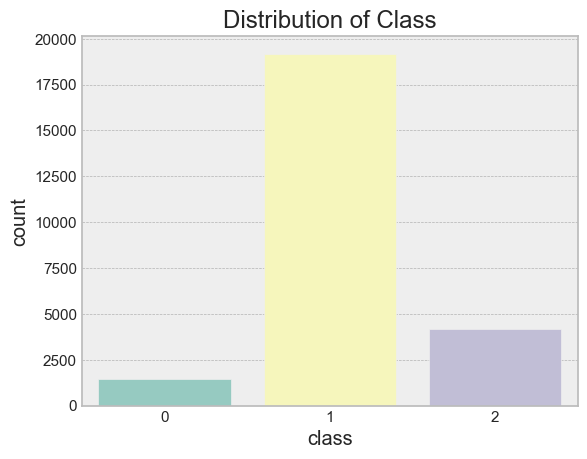

In [12]:
df['class'] = df['class'].astype(int)

sns.countplot(x='class', data=df, palette='Set3')
plt.title('Distribution of Class')
plt.show()

## Creating new column `label` for hate speech binary

In the original data, the `class` column identifies each tweet as 0 for hate speech, 1 for offensive language or 2 for neither. 

We will be changing offensive language to 2, and identifying that all to 0 for **not hate speech**. And changing hate specch to 1.

In [13]:
df['label'] = df['class'].replace(1, 2)

In [14]:
df.label.unique()

array([2, 0])

In [15]:
# changing hate speech to 1 and not hate speech to 0
df['label'] = df['label'].replace(0, 1)
df['label'] = df['label'].replace(2, 0)

In [16]:
df.label.unique()

array([0, 1])

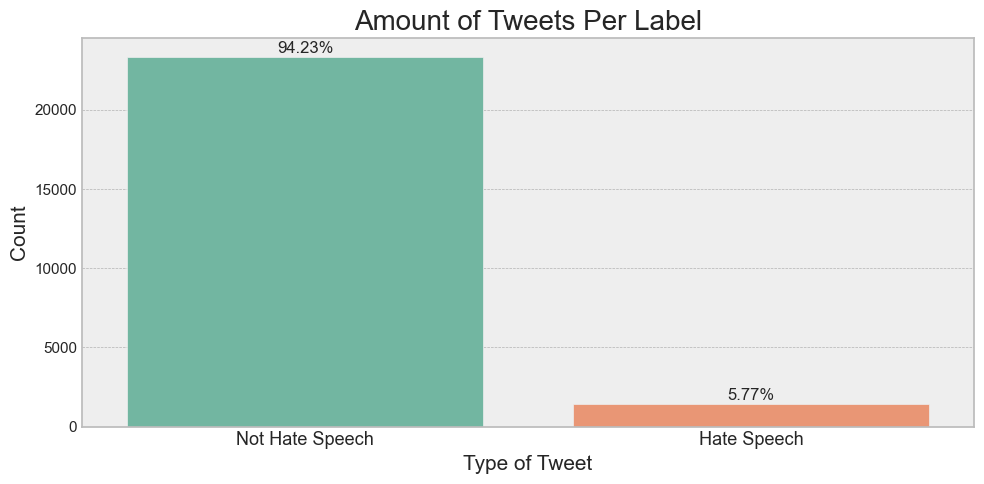

In [ ]:
plt.figure(figsize=(10, 5))
df['label'] = df['label'].astype(int)

ax = sns.countplot(x='label', data=df, palette='Set2')
ax.set_title('Amount of Tweets Per Label', fontsize=20)
ax.set_xlabel('Type of Tweet', fontsize=15)
ax.set_ylabel('Count', fontsize=15)

ax.set_xticklabels(['Not Hate Speech', 'Hate Speech'], fontsize=13)

total = float(len(df))
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2.,
            height + total * 0.01,  
            '{:.2f}%'.format(100 * height / total),
            ha='center', fontsize=12)

plt.tight_layout()
plt.show()


In [20]:
# we can see that only 5.7% of the data is actual hate speech
df['label'].sum() / len(df['label'])

0.05770084332001776

## Creating new `clean_df` with renamed columns

Changes from original df:
- dropping the class column
- renmaing `count` to `total_votes`
- renaming `hate_speech` to `hate_speech_votes`
- adding together `offensive_language` and `neither` to become `other_votes`

In [21]:
# creating new dataframe `clean_df`
raw_df = df[['count', 'hate_speech', 'offensive_language', 'neither', 'tweet', 'label']].copy()

In [22]:
# renaming those columns
raw_df.rename(columns={'count':'total_votes', 'hate_speech': 'hate_speech_votes', }, inplace=True)

In [23]:
# creating column for vote count for not hate speech tweets
raw_df['other_votes'] = raw_df['offensive_language'] + raw_df['neither']

In [24]:
# reordering the columns and dropping the old 'offensive_language' and 'neither' columns
raw_df = raw_df.reindex(columns=['total_votes', 'hate_speech_votes', 'other_votes','label', 'tweet'])

In [25]:
# checking that it all worked
raw_df.head()

,total_votes,hate_speech_votes,other_votes,label,tweet
0,3,0,3,0,!!! RT @mayasolovely: As a woman you shouldn't...
1,3,0,3,0,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,3,0,3,0,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,0,3,0,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,6,0,6,0,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


In [26]:
# pickling the raw tweets for later EDA
raw_df.to_pickle("raw_tweets_df.pkl")

## Cleaning `tweet` column - first round

In [27]:
# copying new `clean_df` and cleaning up the tweets
clean_df = raw_df.copy()

In [28]:
clean_df.head()

,total_votes,hate_speech_votes,other_votes,label,tweet
0,3,0,3,0,!!! RT @mayasolovely: As a woman you shouldn't...
1,3,0,3,0,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,3,0,3,0,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,0,3,0,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,6,0,6,0,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


In [29]:
# function to clean all data
def clean_text_round1(text):
    '''Make text lowercase, remove text in square brackets, remove punctuation and remove words containing numbers.'''
    # make text lowercase
    text = text.lower()
    # removing text within brackets
    text = re.sub('\[.*?\]', '', text)
    # removing text within parentheses
    text = re.sub('\(.*?\)', '', text)
    # removing numbers
    text = re.sub('\w*\d\w*', '', text)
    # if there's more than 1 whitespace, then make it just 1
    text = re.sub('\s+', ' ', text)
    # if there's a new line, then make it a whitespace
    text = re.sub('\n', ' ', text)
    # removing any quotes
    text = re.sub('\"+', '', text)
    # removing &amp;
    text = re.sub('(\&amp\;)', '', text)
    # removing any usernames
    text = re.sub('(@[^\s]+)', '', text)
    # removing any hashtags
    text = re.sub('(#[^\s]+)', '', text)
    # remove `rt` for retweet
    text = re.sub('(rt)', '', text)
    # string.punctuation is a string of all punctuation marks
    # so this gets rid of all punctuation
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    # getting rid of `httptco`
    text = re.sub('(httptco)', '', text)

    return text

round1 = lambda x: clean_text_round1(x)

In [30]:
# appling data cleaning function to `tweet` column
clean_df['clean_tweets'] = clean_df['tweet'].apply(round1)

In [31]:
# checking that it worked
clean_df.head()

,total_votes,hate_speech_votes,other_votes,label,tweet,clean_tweets
0,3,0,3,0,!!! RT @mayasolovely: As a woman you shouldn't...,as a woman you shouldnt complain about clea...
1,3,0,3,0,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...,boy dats coldtyga dwn bad for cuffin dat ho...
2,3,0,3,0,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...,dawg you ever fuck a bitch and she sta to...
3,3,0,3,0,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...,she look like a tranny
4,6,0,6,0,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...,the shit you hear about me might be true or...


In [32]:
# checking for missing values
clean_df.isnull().sum()

total_votes          0
hate_speech_votes    0
other_votes          0
label                0
tweet                0
clean_tweets         0
dtype: int64

## Pickling `clean_df` for later use
If there needs to be further data cleaning or preprocessing, that will be done in other notebooks

In [33]:
clean_df.to_pickle("clean_df.pkl")